In [20]:
if (!require("C50")) install.packages("C50")
if (!require("entropy")) install.packages("entropy")
if (!require("ggplot2")) install.packages("ggplot2")

# Entscheidungsbäume - Decision Trees
Entscheidungsbäume sind ein grundlegendes Element des [überwachten Lernens](https://en.wikipedia.org/wiki/Supervised_learning) und gehören zur Klasse des maschinellen Lernens. Beim überwachten maschinellen Lernen wird automatisch aus einem Trainingsset ein Regelwerk erstellt, welches zu einem späteren Zeitpunkt zur Entscheidungsunterstützung für unbekannte Datenwerte dient.

Ein Entscheidungsbaum besteht immer aus einem Wurzelknoten und beliebig vielen inneren Knoten sowie mindestens zwei Blättern. Dabei repräsentiert jeder Knoten eine logische Regel und jedes Blatt eine Antwort auf das Entscheidungsproblem.

## Beispiel
Ein Profi-Golfer wird beobachtet, wann er zum Golfen geht. Amateure wollen aus seinem Verhalten lernen wann es sich lohnt, Golf zu spielen:

In [21]:
golf.data <- read.csv("DecisionTree/golf/golf.csv")
head(golf.data)

,Vorhersage,Temperatur,Luftfeuchte,windig,Golfen
1,sonnig,85,85,nein,nicht spielen
2,sonnig,80,90,ja,nicht spielen
3,bedeckt,83,78,nein,spielen
4,regen,70,96,nein,spielen
5,regen,68,80,nein,spielen
6,regen,65,70,ja,nicht spielen


Ein Entscheidungsbaumalgorithmus erstellt daraus diesen Entscheidungsbaum:

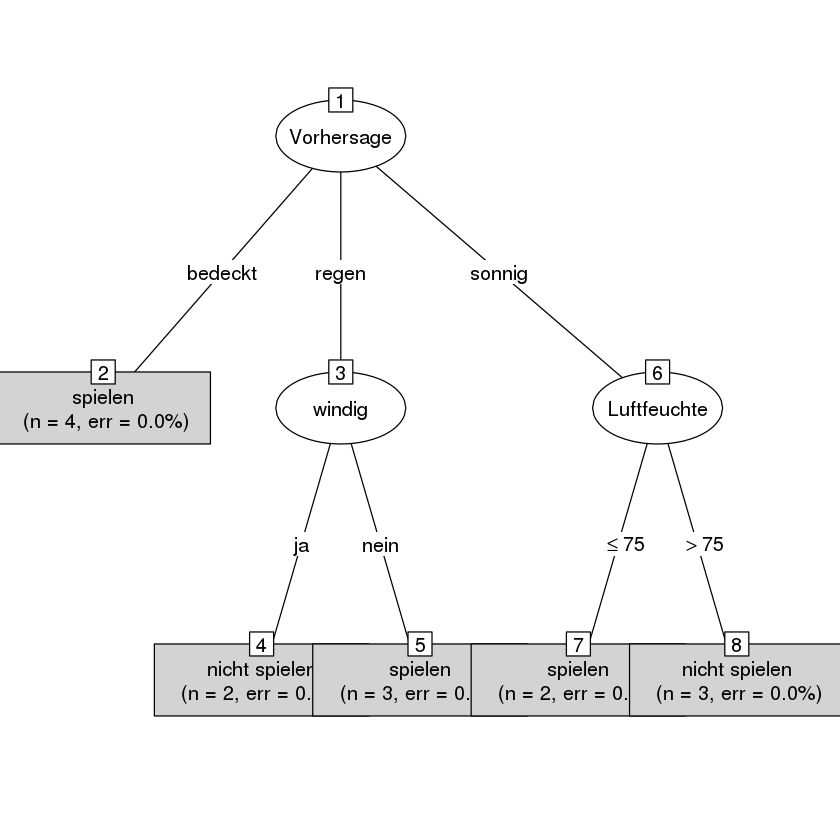

In [22]:
golf.tree<-C5.0(Golfen~.,data=golf.data)
plot(golf.tree, type = "simple")

Der Entscheidungsbaum ist so zu lesen: Wenn die Vorhersage _bedeckt_ ist, dann soll man golfen gehen. Ist die Vorhersage hingegen _regen_ oder _sonnig_, dann ist es weiters abhängig von der Luftfeuchte. Beträgt die Luftfeuchte > 75%, dann sollte man nicht spielen gehen.

Der Entscheidungsbaum hat aus den Größen _Golfen_ von den Größen _Vorhersage_, _Temperatur_, _Luftfeuchte_, und _windig_ in Relation zur Entscheidung golfen zu gehen Abhängigkeiten erkannt und daraus Regeln erstellt. In diesem Zusammenhang stellen sich die Fragen wie es zur Erstellung dieses Baums kommt, speziell wann welche Entscheidung getroffen wird und warum.

Entscheidungsbäume können automatisiert aus vorgegebenen Zielgrößen Zusammenhänge in Datenbeständen erkennen und daraus Regeln zur Entscheidungsunterstützung ableiten. Diese automatisiert erkannten Regeln müssen begründbar sein, daher ist es erforderlich, sich mit den Wirkweisen der Entscheidungsbaumerstellung auseinanderzusetzen. Die wichtigste Grundlage dazu stellt die [Entropie](https://de.wikipedia.org/wiki/Entropie_(Informationstheorie)) dar.

# Entropie
Die Entropie ist in der Informationstheorie ein Maß für die benötigte Breite zur Übertragung oder Speicherung von Informationen.

## Exkurs
Eine Ampel (die aus den Lichtern Rot und Grün besteht) blinkt 1 Mal pro Tag. Wir wissen, dass das rote Licht ausgefallen ist. Die benötigte Bandbreite zur Übertragung dieser Information bzw. der Informationsgehalt ist 0 - Es ist sicher, dass die Ampel immer grün blinken wird.

Wenn beide Lichter der Ampel funktionieren und die Regel lautet, dass ein Licht immer abwechselnd leuchten muss, dann herrscht perfekte Unkenntnis über das nächste einzutretende Ereignis und der Informationsgewinn, also der Wert der Information sobald das nächste Ereignis eintritt, ist am höchsten. Gleiches gilt wenn es drei Farben an Lichtern gäbe, z.B. Gelb, die immer abwechselnd leuchten dürfen: Indem die Homogenität der Eintrittswahrscheinlichkeiten der Ereignisse gleichverteilt ist, haben solche Ereignisse den höchsten Informationsgehalt.

Geht man wieder auf das Modell der zwei Farben zurück, und führt aber die weitere Regel ein, dass das rote Licht nicht zwei Mal hintereinander leuchten darf, dann ändert sich der Gehalt dieses Informationssystems, denn wenn das rote Licht leuchtete, wird das nächste Licht jedenfalls Grün sein.

Verallgemeinernd kann der Informationsgehalt eines Ereignisses berechnet werden aus $-p \log_2(p)$ wobei p die Eintrittswahrscheinlichkeit des Ereignisses ist.

Aus dem Zusammenhang der Eintrittswahrscheinlichkeit von Ereignissen (in unserem Beispiel die Wahrscheinlichkeiten des Leuchtens der Lichter Rot, Grün oder Gelb) und der Anzahl der verschiedenen Ausprägungen der Ereignisse (die Ampel kann Rot, Grün oder Gelb blinken, somit 3 unterschiedliche Ausprägungen), kann der Informationsgehalt des Gesamtsystems berechnet werden aus:

$$I=-\sum p_i  \log_2 (p_i)$$

Für das Beispiel der Ampel mit den jeweils unterschiedlich farbigen Lichtern und den dazugehörigen Regeln ergeben sich diese Werte:

Rote Glühbirne ausgebrannt: $p_{red} = 0$, $p_{green}=1$, $I = -(0 + 0)  = 0$  
Rot und Grün mit gleicher Wahrscheinlichkeit: $p_{red} = \frac{1}{2}$, $p_{green} = \frac{1}{2}$, $I = -(2 \frac{1}{2}  \log_2\frac{1}{2}) = log_2 2$  
Drei Farben mit gleicher Eintrittswahrscheinlichkeit: $p_i=\frac{1}{3}$, $I = -(3 \frac{1}{3}  \log_2 \frac{1}{3}) = log_2(3)$  
Grün und Rot, Grün zwei mal so wahrscheinlich: $p_{red}=\frac{1}{3}$, $p_{green}=\frac{2}{3}$, $I = -(\frac{1}{3} \log_2 \frac{1}{3} + \frac{2}{3} \log_2 \frac{2}{3}) = \log_2 3 - \frac{2}{3} \log_2 2$

Ein Ziel beim Erstellen eines Entscheidungsbaumes ist es die Tiefe und somit die Anzahl seiner Regeln, gering zu halten. Dies wird ermöglicht, indem bei jedem Knoten jene Entscheidungsvariablen gewählt werden, die das Entscheidungsproblem möglichst rasch so partitionieren, dass die verbleibende Menge an zu treffenden Entscheidungen reduziert wird.

Dazu wird für die einzelnen Entscheidungsvariablen deren Entropie am Entscheidungssystem bestimmt und jene Variable gewählt, die den höchsten _Informationsgewinn_ liefert. Der Informationsgewinn berechnet sich aus der _Entropie vor der Teilung_ - _Entropie nach der Teilung_. Zur Bestimmung ob der Split des Entscheidungsbaums in Bezug auf die Variable _windig_ oder _Vorhersage_ erfolgen soll, muss daher jeweils der Informationsgewinn berechnet werden.

Zuerst wird ermittelt, wie viele unterschiedliche Ausprägungen der Zielvariable es gibt sowie deren Frequenz (Häufigkeit des Auftretens):

In [23]:
xtabs(~Golfen,data=golf.data)

Golfen
nicht spielen       spielen 
            5             9 

Anschließend werden die Wahrscheinlichkeiten berechnet, mit denen eine jeweilige Ausprägung der Zielvariable auftreten kann. Die Wahrscheinlichkeit beträgt $\frac{X_i}{|T|}$, wobei $X$ die Anzahl der Ausprägungen einer Zielvariable ist (hier z.B. _nicht spielen_) und $|T|$ die Gesamtanzahl der Ereignisse:

In [24]:
xtabs(~Golfen,data=golf.data)[1]
xtabs(~Golfen,data=golf.data)[1] / nrow(golf.data)

prop.golf<-prop.table(xtabs(~Golfen,data=golf.data))

prop.golf

nicht spielen 
            5

nicht spielen 
    0.3571429

Golfen
nicht spielen       spielen 
    0.3571429     0.6428571 

Die Entropie vor einem Split $I(5/9)$ beträgt somit nach Einsetzen in die Formel für die Entropie $I=-\sum p_i  \log_2 (p_i)$:

In [25]:
p.nicht_spielen<-prop.golf['nicht spielen']
p.spielen<-prop.golf['spielen']

as.numeric(- (p.nicht_spielen * log2(p.nicht_spielen) + p.spielen * log2(p.spielen)))

[1] 0.940286

Alternativ gelangen diese beiden Ausdrücke zum gleichen Ergebnis:

In [26]:
-sum(prop.golf*log2(prop.golf))

I<-entropy.empirical(prop.golf, unit="log2")
I

[1] 0.940286

[1] 0.940286

Die Entropie nach der Teilung anhand der _Vorhersage_ berechnet sich wie folgt:
1. Die Anzahl der unterschiedlichen Ausprägungen von _Vorhersage_ wird relativ zur Zielvariable _Golfen_ ermittelt:
2. Berechnen der Eintrittswahrscheinlichkeiten der unterschiedlichen Ausprägungen von _Vorhersage_ relativ zur Zielvariablen
3. Berechnung der jeweiligen Entropien
4. Die Gesamtentropie berechnet sich wieder analog aus der - Summe (Wahrscheinlichkeit des Eintritts des Ereignisses * jeweiligen Einzelentropie), $I=-\sum p_i  \log_2 (p_i)$

In [27]:
xtabs(~Golfen+Vorhersage,data=golf.data)

               Vorhersage
Golfen          bedeckt regen sonnig
  nicht spielen       0     2      3
  spielen             4     3      2

Berechnung der jeweiligen Eintrittswahrscheinlichkeiten:

In [28]:
prop.golf.Vorhersage <- t(prop.table(xtabs(~Golfen+Vorhersage,data=golf.data)))
prop.golf.Vorhersage

          Golfen
Vorhersage nicht spielen   spielen
   bedeckt     0.0000000 0.2857143
   regen       0.1428571 0.2142857
   sonnig      0.2142857 0.1428571

Berechnung der jeweiligen Einzelentropien (bedeckt, regen, sonnig):

In [29]:
entropy.empirical(prop.golf.Vorhersage[1,], unit="log2")
entropy.empirical(prop.golf.Vorhersage[2,], unit="log2")
entropy.empirical(prop.golf.Vorhersage[3,], unit="log2")

ent.golf.Vorhersage<-apply(prop.golf.Vorhersage, 1, function(x) entropy.empirical(x, unit="log2"))
ent.golf.Vorhersage

[1] 0

[1] 0.9709506

[1] 0.9709506

bedeckt     regen    sonnig 
0.0000000 0.9709506 0.9709506

## Informationsgewinn
Der Informationsgewinn bzw. die Reduktion der Unsicherheit des Teilsystems _Vorhersage_ errechnet sich somit aus $p_{(bedeck|Golfen)}  I(p_{(bedeck|Golfen)}) + p_{(regen|Golfen)} I(p_{(regen|Golfen)}) + p_{(sonnig|Golfen)} I(p_{(sonnig|Golfen)})$:

In [30]:
I.Vorhersage <- sum(prop.golf.Vorhersage*ent.golf.Vorhersage)
I.Vorhersage

[1] 0.6935361

und der Informationsgewinn beträgt _Entropie vor dem Split - Entropie nach dem Split_ = $I(Golf) - I(Golf|Vorhersage)$:

In [31]:
I-I.Vorhersage

[1] 0.2467498

Der Informationsgewinn für das mögliche Teilsystem _windig_ wird analog berechnet und beträgt:

In [32]:
prop.golf.windig<-t(prop.table(xtabs(~Golfen+windig,data=golf.data)))
ent.golf.windig<-apply(prop.golf.windig,1, function(x) entropy.empirical(x, unit="log2"))
    
I.windig <- sum(prop.golf.windig*ent.golf.windig)

I-I.windig

[1] 0.04812703

Ein Split des Entscheidungsbaumes bezüglich der _Vorhersage_ wäre also zu bevorzugen, da er den höheren Informationsgewinn liefert.

## Binning
Die beschriebene Vorgehensweise ist für diskrete Werte wie **windig{ja|nein}** oder **Vorhersage{regen|bedeckt|sonnig}** möglich. Für kontinuierliche Werte wie Temperatur oder Luftfeuchte muss eine andere Vorgehensweise gewählt werden, die als _Binning_ bezeichnet wird. Binning ist die automatische Zuordnung kontinuierlicher Werte zu Klassen. Im Fall von Temperatur würden sich beispielsweise die Klassenwerte **Temperatur{niedrig|angenehm|heiß}** anbieten. Um diese Klassenbildung zu verdeutlichen kann für das gewählte Beispiel folgendes Diagramm erstellt werden:

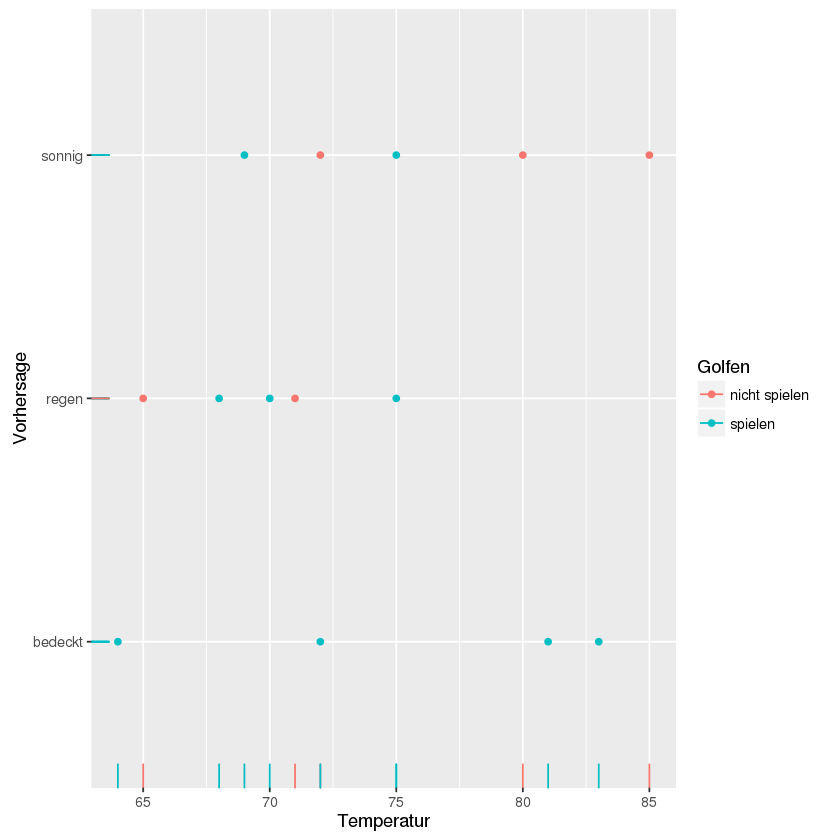

In [35]:
ggplot(data = golf.data, aes(x = Temperatur, y = Vorhersage, color=Golfen)) + geom_point() + geom_rug()

Ein ersichtlicher Trend ist, das wenn Temperatur und Luftfeuchte hoch sind, man eher _nicht_ spielen sollte. Hingegen ist es bei hoher Temperatur und niedriger Luftfeuchte anscheinend vorteilhaft zu spielen.

Betrachtet man die Verteilung der Werte Temperatur so lässt sich eine Dreierklassifikation in niedrig, angenehm und heiß argumentieren. Auch hinsichtlich der Luftfeuchte kann man erkennen, dass z.B. für eine Luftfeuchte von > 75 bis auf eine sämtliche Entscheidungen nicht zu spielen lauten.

Entscheidungsbaumalgorithmen nehmen eine automatische Klassifikation kontinuierlicher Werte hinsichtlich ihrer Verteilung und ihres Einflusses auf die Zielvariable vor.

## Wie geht es weiter?
Der hier vorgestellte Entscheidungsbaumalgorithmus C5.0 wählt eine iterative Vorgehensweise. Nachdem der erste Split gewählt wurde, wird für alle weiteren verbleibenden Inputgrößen deren Informationsgewinn bestimmt und die Menge der verbleibenden Entscheidungen weiter reduziert, bis das Entscheidungsproblem gelöst ist.

Für das gewählte Entscheidungsproblem "Golfen" lauten die Regeln:

In [34]:
summary(golf.tree)


Call:
C5.0.formula(formula = Golfen ~ ., data = golf.data)


C5.0 [Release 2.07 GPL Edition]  	Sun Oct 23 16:50:04 2016
-------------------------------

Class specified by attribute `outcome'

Read 14 cases (5 attributes) from undefined.data

Decision tree:

Vorhersage = bedeckt: spielen (4)
Vorhersage = regen:
:...windig = ja: nicht spielen (2)
:   windig = nein: spielen (3)
Vorhersage = sonnig:
:...Luftfeuchte <= 75: spielen (2)
    Luftfeuchte > 75: nicht spielen (3)


Evaluation on training data (14 cases):

	    Decision Tree   
	  ----------------  
	  Size      Errors  

	     5    0( 0.0%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	     5          (a): class nicht spielen
	           9    (b): class spielen


	Attribute usage:

	100.00%	Vorhersage
	 35.71%	Luftfeuchte
	 35.71%	windig


Time: 0.0 secs
